In [23]:
import cfbd
import pandas as pd
import concurrent.futures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# Configuration
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'JOo7NPQiRwoWx1kDmv1VDiujh+ra/nfYLRGy0TVt2KhLM+Yiu6BpXOC7W4YtjBdq'
configuration.api_key_prefix['Authorization'] = 'Bearer'
# Initialize API instances
games_api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))
stats_api_instance = cfbd.StatsApi(cfbd.ApiClient(configuration))

In [24]:
def fetch_big_12_teams():
    teams_api = cfbd.TeamsApi(cfbd.ApiClient(configuration))
    all_teams = teams_api.get_teams()
    return {team.school for team in all_teams if team.conference == 'Big 12'}

# Fetch Big 12 teams
big_12_teams = fetch_big_12_teams()
print(big_12_teams)

{'TCU', 'West Virginia', 'Kansas State', 'Kansas', 'Oklahoma State', 'Texas', 'Oklahoma', 'Iowa State', 'Baylor', 'Texas Tech'}


In [25]:
def fetch_games_data_for_years(start_year, end_year, big_12_teams):
    dataframes = {}
    for year in range(start_year, end_year + 1):
        all_games = []
        for team in big_12_teams:
            games = games_api_instance.get_games(year=year, team=team)
            all_games.extend(games)
        
        big_12_games = [game for game in all_games if game.home_team in big_12_teams and game.away_team in big_12_teams]

        game_data = pd.DataFrame.from_records(
            [dict(game_id=game.id,
                  year=game.season,
                  home_team=game.home_team,
                  away_team=game.away_team,
                  home_points=game.home_points,
                  away_points=game.away_points) for game in big_12_games]
        )
        dataframes[year] = game_data
    return dataframes

In [26]:
def fetch_advanced_stats_for_year(year, big_12_teams):
    all_advanced_stats = []
    for team in big_12_teams:
        advanced_stats = stats_api_instance.get_advanced_team_game_stats(year=year, team=team)
        all_advanced_stats.extend(advanced_stats)
    
    big_12_advanced_stats = [stat for stat in all_advanced_stats if stat.team in big_12_teams and stat.opponent in big_12_teams]

    return year, pd.DataFrame.from_records(
        [dict(game_id=stat.game_id,
              team=stat.team,
              opponent=stat.opponent,
              line_yards_total=stat.offense.line_yards_total,
              second_level_yards_total=stat.offense.second_level_yards_total,
              open_field_yards_total=stat.offense.open_field_yards_total,
              total_points=stat.offense.total_ppa,
              total_plays=stat.offense.plays) for stat in big_12_advanced_stats]
    )

def fetch_advanced_team_stats_for_years(start_year, end_year, big_12_teams):
    advanced_stats_data = {}
    years = list(range(start_year, end_year + 1))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(fetch_advanced_stats_for_year, year, big_12_teams): year for year in years}
        for future in concurrent.futures.as_completed(futures):
            year = futures[future]
            try:
                data = future.result()
                advanced_stats_data[year] = data[1]
            except Exception as exc:
                print(f"Year {year} generated an exception: {exc}")

    return advanced_stats_data

In [27]:
def calculate_point_differential(df):
    df['point_differential'] = df['home_points'] - df['away_points']

In [28]:
# Fetch data
years_data = fetch_games_data_for_years(2016, 2020, big_12_teams)

In [29]:
advanced_stats_data = fetch_advanced_team_stats_for_years(2016, 2020, big_12_teams)

In [34]:
# Combine data
combined_data = pd.concat(years_data.values(), ignore_index=True)
advanced_stats_combined = pd.concat(advanced_stats_data.values(), ignore_index=True)

# Calculate point differential and merge datasets
calculate_point_differential(combined_data)
combined_data_with_advanced_stats = combined_data.merge(advanced_stats_combined, left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='inner')
combined_data_with_advanced_stats.drop('team', axis=1, inplace=True)

# Prepare dataset for model training
df = combined_data_with_advanced_stats.dropna()
df = df.drop_duplicates()
X = df[['line_yards_total', 'second_level_yards_total', 'open_field_yards_total', 'total_points', 'total_plays']]
y = df['point_differential']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
# Normalize the input features for both train and test sets
X_train_normalized_lr = scaler.fit_transform(X_train)
X_test_normalized_lr = scaler.transform(X_test)

# Train the linear regression model on the normalized data
model_lr = LinearRegression()
model_lr.fit(X_train_normalized_lr, y_train)

# Predict point differentials for the test dataset
y_pred = model_lr.predict(X_test_normalized_lr)

# Calculate mean squared error and R^2 score for the linear regression model
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred_lr)

# Print results
print("Mean Squared Error: {:.2f}".format(mse))
print("R^2 Score: {:.2f}".format(r2))

Mean Squared Error: 222.80
R^2 Score: 0.33


In [36]:
# 1. Fetch game data and advanced team stats for the 2021 season
games_2021 = fetch_games_data_for_years(2021, 2021, big_12_teams)
advanced_stats_2021 = fetch_advanced_team_stats_for_years(2021, 2021, big_12_teams)

# 2. Preprocess the data
combined_data_2021 = pd.concat(games_2021.values(), ignore_index=True)
calculate_point_differential(combined_data_2021)
advanced_stats_combined_2021 = pd.concat(advanced_stats_2021.values(), ignore_index=True)
combined_data_with_advanced_stats_2021 = combined_data_2021.merge(
    advanced_stats_combined_2021,
    left_on=['game_id', 'home_team'],
    right_on=['game_id', 'team'],
    how='inner'
)
combined_data_with_advanced_stats_2021.drop('team', axis=1, inplace=True)
df_2021 = combined_data_with_advanced_stats_2021.dropna()
df_2021 = df_2021.drop_duplicates()
X_2021 = df_2021[['line_yards_total', 'second_level_yards_total', 'open_field_yards_total', 'total_points', 'total_plays']]
y_actual_2021 = df_2021['point_differential']

# Normalize
X_2021_normalized_lr = scaler.transform(X_2021)


# 3. Use your trained model to predict point differentials for the 2021 games
y_pred_2021 = model_lr.predict(X_2021_normalized_lr)

# 4. Compare the predicted point differentials with the actual point differentials
mse_2021 = mean_squared_error(y_actual_2021, y_pred_2021)
r2_2021 = r2_score(y_actual_2021, y_pred_2021)

print("Mean Squared Error for 2021: {:.2f}".format(mse_2021))
print("R^2 Score for 2021: {:.2f}".format(r2_2021))


Mean Squared Error for 2021: 211.64
R^2 Score for 2021: 0.42


In [37]:
# Add the predicted point differentials as a new column in the DataFrame
df_2021['predicted_point_differential'] = y_pred_2021

df_2021[['home_team','away_team','point_differential','predicted_point_differential']]

,home_team,away_team,point_differential,predicted_point_differential
0,TCU,Texas,-5,9.991538
2,Texas Tech,TCU,-21,5.039573
4,Oklahoma,TCU,21,24.304288
6,TCU,West Virginia,-12,10.957483
8,Kansas State,TCU,19,7.735669
10,TCU,Baylor,2,9.007098
12,TCU,Kansas,3,17.575229
14,Iowa State,TCU,34,24.226440
18,West Virginia,Texas Tech,-3,8.434684
20,Baylor,West Virginia,25,19.354458


In [38]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [39]:
# 2. Normalize the input features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
X_2021_normalized = scaler.transform(X_2021)

In [41]:
# 3. Create a neural network model
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [42]:
# Compile the model
model_nn.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
# 4. Train the model on your dataset
model_nn.fit(X_train_normalized, y_train, epochs=100, batch_size=32, verbose=0)

In [44]:
# 5. Evaluate the model's performance and make predictions
y_pred_nn = model_nn.predict(X_test_normalized).flatten()
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print("Mean Squared Error for Neural Network: {:.2f}".format(mse_nn))
print("R^2 Score for Neural Network: {:.2f}".format(r2_nn))

2/2 [==============================] - 0s 3ms/step
Mean Squared Error for Neural Network: 214.92
R^2 Score for Neural Network: 0.35


In [45]:
# Make predictions for the 2021 season
y_pred_2021_nn = model_nn.predict(X_2021_normalized).flatten()

2/2 [==============================] - 0s 3ms/step


In [46]:
# Add the neural network predictions to the DataFrame
df_2021['predicted_point_differential_nn'] = y_pred_2021_nn

In [47]:
# Filter the DataFrame to only include games where both teams are from the Big 12 conference
big_12_games_2021 = df_2021[df_2021['home_team'].isin(big_12_teams) & df_2021['away_team'].isin(big_12_teams)]

# Display the filtered DataFrame with the actual and predicted point differentials
print(big_12_games_2021[['home_team', 'away_team', 'point_differential', 'predicted_point_differential', 'predicted_point_differential_nn']])


         home_team       away_team  point_differential  \
0              TCU           Texas                  -5   
2       Texas Tech             TCU                 -21   
4         Oklahoma             TCU                  21   
6              TCU   West Virginia                 -12   
8     Kansas State             TCU                  19   
10             TCU          Baylor                   2   
12             TCU          Kansas                   3   
14      Iowa State             TCU                  34   
18   West Virginia      Texas Tech                  -3   
20          Baylor   West Virginia                  25   
22   West Virginia      Iowa State                   7   
24   West Virginia  Oklahoma State                 -21   
26    Kansas State   West Virginia                  17   
28   West Virginia           Texas                   8   
30          Kansas   West Virginia                  -6   
32  Oklahoma State    Kansas State                  11   
34    Kansas S

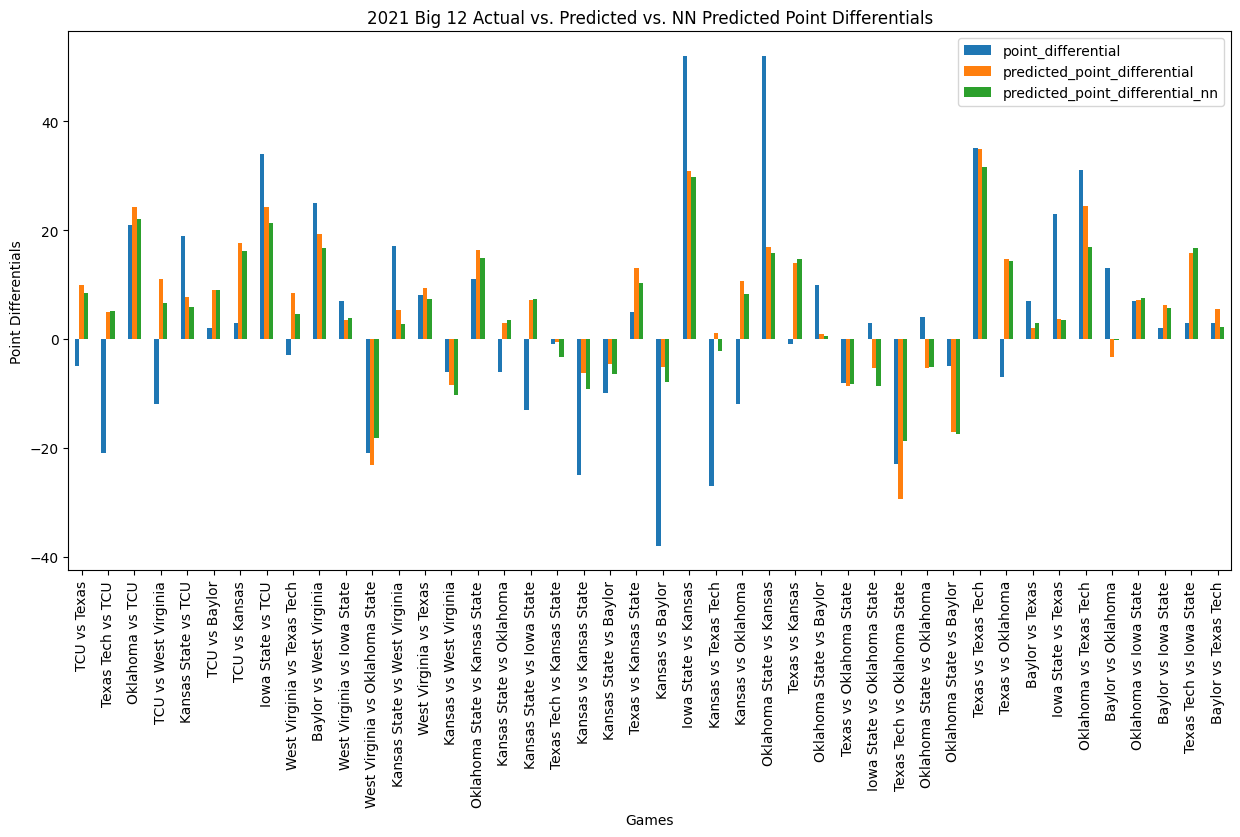

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Set the index for the DataFrame to be a combination of home_team and away_team
big_12_games_2021.index = big_12_games_2021['home_team'] + " vs " + big_12_games_2021['away_team']

# Create a bar chart comparing actual, predicted, and nn_predicted point differentials
ax = big_12_games_2021[['point_differential', 'predicted_point_differential', 'predicted_point_differential_nn']].plot(kind='bar', figsize=(15, 7))

# Set labels and title
ax.set_ylabel("Point Differentials")
ax.set_xlabel("Games")
ax.set_title("2021 Big 12 Actual vs. Predicted vs. NN Predicted Point Differentials")

# Show the plot
plt.show()